Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [254]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [255]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [256]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [257]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2238
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [258]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [259]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=123,
validation_split=0.2,
subset='training',
image_size=(img_height,img_width),
batch_size=batch_size)

Found 2238 files belonging to 9 classes.
Using 1791 files for training.


In [260]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=123,
validation_split=0.2,
subset='validation',
image_size=(img_height,img_width),
batch_size=batch_size)

Found 2238 files belonging to 9 classes.
Using 447 files for validation.


In [261]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

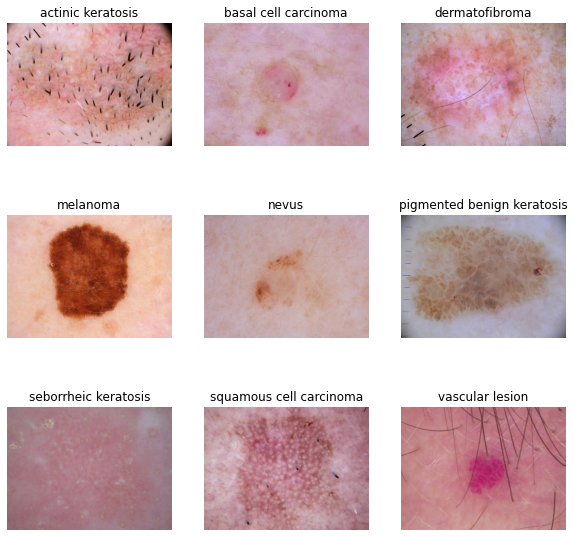

In [262]:
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for cnt,name in enumerate(class_names):
  ax = plt.subplot(3,3,cnt+1)
  image = list(data_dir_train.glob(name + "/*"))[0]
  img = imgplt.imread(str(image))
  plt.imshow(img)
  plt.title(name)
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [263]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [264]:
### Your code goes here
model = Sequential([
    layers.Input(shape=(180,180,3)),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,padding="same",activation='relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9,activation="softmax")
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [265]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [266]:
model.build

<bound method Sequential.build of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7975f84ed0>>

In [267]:
# View the summary of all layers
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_30 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
flatten_31 (Flatten)         (None, 259200)          

### Train the model

In [268]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 113s 2s/step - loss: 3.6435 - accuracy: 0.1900 - val_loss: 2.0659 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9072 - accuracy: 0.2735 - val_loss: 1.8869 - val_accuracy: 0.3311
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.8461 - accuracy: 0.3059 - val_loss: 2.4610 - val_accuracy: 0.2304
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8718 - accuracy: 0.3119 - val_loss: 1.7396 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5742 - accuracy: 0.4348 - val_loss: 1.6461 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4145 - accuracy: 0.4840 - val_loss: 1.5708 - val_accuracy: 0.4698
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3777 - accuracy: 0.5127 - val_loss: 1.8728 - val_accuracy: 0.4027
Epoch 8/20
56

### Visualizing training results

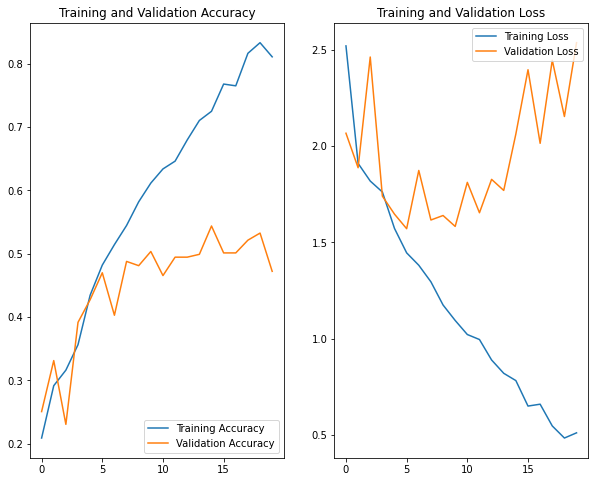

In [269]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

 - There is a huge gap between training and test accuracies.
 - The training loss is also very less as compared to validation loss.
 - This phenomenon of less accuracy in validation as opposed to high accuracy in training clearly indicates that there is Overfitting of data.
 

In [270]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
augmentation = Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(180,180,3)),
     layers.experimental.preprocessing.RandomRotation(0.3)
    ]
)

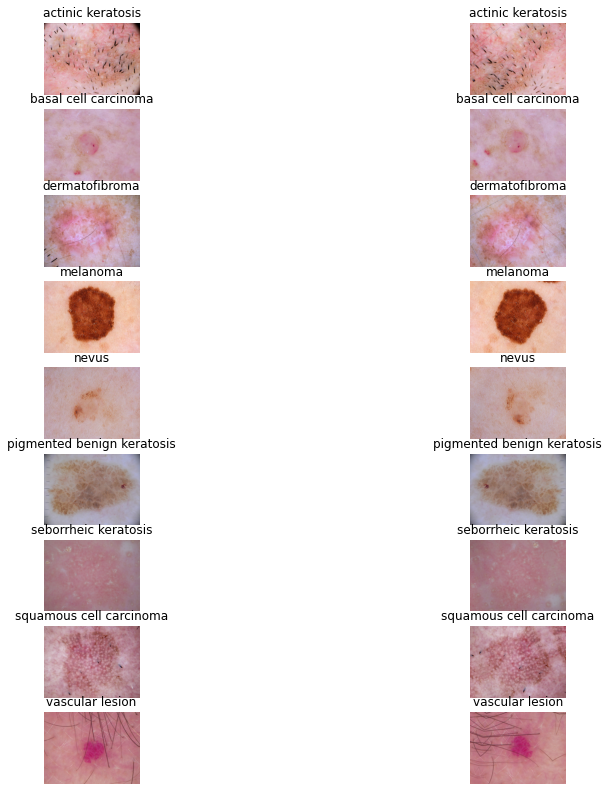

In [271]:
# Visualize whether Augmentation strategy Works for one instance of training image
plt.figure(figsize=(14,14))
cnt = 0
for name in class_names:
  cnt= cnt+1
  ax = plt.subplot(9,2,cnt)
  image = list(data_dir_train.glob(name + "/*"))[0]
  img = imgplt.imread(str(image))
  plt.imshow(img)
  plt.title(name)
  plt.axis("off")
  cnt = cnt+1
  ax = plt.subplot(9,2,cnt)
  aug_img = augmentation(
      tf.expand_dims(img,0), training = True
  )
  plt.imshow(aug_img[0].numpy().astype("int32"));
  plt.title(name)
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [272]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    augmentation,
    layers.Conv2D(32,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128,3,padding="same",activation='relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9,activation="softmax")
])



### Compiling the model

In [273]:
## Your code goes here
model.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

### Training the model

In [274]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 4.8445 - accuracy: 0.1779 - val_loss: 1.9679 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 2.0313 - accuracy: 0.2699 - val_loss: 1.8680 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.7764 - accuracy: 0.3787 - val_loss: 1.7509 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6066 - accuracy: 0.4477 - val_loss: 1.7532 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.7066 - accuracy: 0.3861 - val_loss: 1.6486 - val_accuracy: 0.4116
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5547 - accuracy: 0.4518 - val_loss: 1.8801 - val_accuracy: 0.3468
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6490 - accuracy: 0.4188 - val_loss: 1.5401 - val_accuracy: 0.4407
Epoch 8/20
56

### Visualizing the results

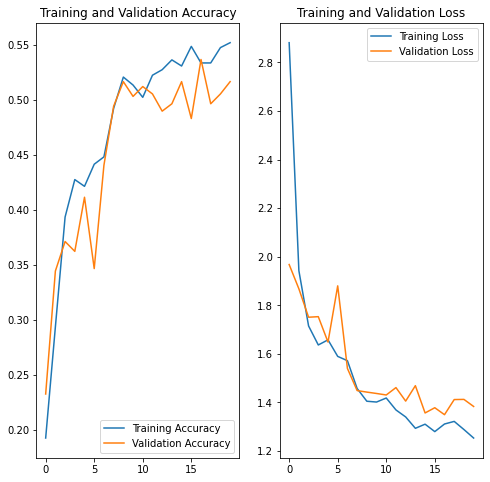

In [275]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

 - The training and validation accuracies are almost same and losses are almost close to each other.
 - However , the accuracies which are expected for a good model are usually higher than the accuracy obtained  and  it is low in both the training and validation sets indicating the model is underfitting.




#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [276]:
## Your code goes here.
img_count = {}
for name in class_names:
  path_file = "/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + name
  data_dir_train_cnt = pathlib.Path(path_file)
  img_count[name] = len(list(data_dir_train_cnt.glob('*.jpg')))
count_df = pd.DataFrame(list(img_count.items()),columns=["name","total"])
count_df

,name,total
0,actinic keratosis,113
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


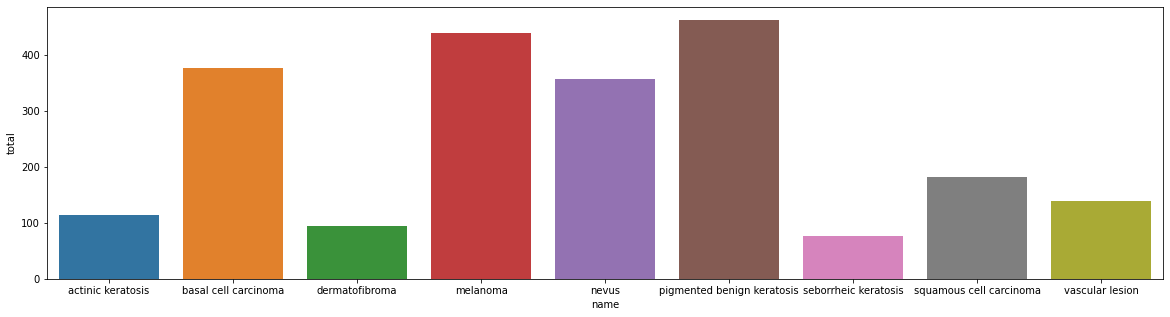

In [277]:
# Plot a graph to analyse counts
plt.figure(figsize=(20,5))
import seaborn as sns
sns.barplot(x='name',y='total',data=count_df)


 - Seborrheic Keratosis has least number of Samples
 - Pigmented Benign Keratosis	and Melanoma dominate the data in terms proportionate number of samples<br>
<b> So, Clearly there is an imbalance and the classes having less samples and mostly likely to result in error predictions thus reducing accuracy</b>


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [278]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [279]:
path_to_training_dataset= str(data_dir_train)+"/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 113 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F77458D3FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7746AA59D0>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7751C09A50>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F7751C116D0>: 100%|██████████| 500/500 [01:30<00:00,  5.56 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x641 at 0x7F77458FC350>: 100%|██████████| 500/500 [01:15<00:00,  6.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7746C0FA90>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F77474FACD0>: 100%|██████████| 500/500 [00:40<00:00, 12.38 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7745556D90>: 100%|██████████| 500/500 [00:18<00:00, 26.70 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7743D27B10>:   0%|          | 1/500 [00:00<01:03,  7.85 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7746AB90D0>: 100%|██████████| 500/500 [00:19<00:00, 26.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [280]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [281]:
from glob2 import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_cb8a38af-2345-4fb5-a8da-3a120b658a94.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_bb6919e0-08d8-4d40-95b8-f935f56df0dd.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_a770f035-37c2-45f3-b068-245d2c987ec7.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_749b033e-9db8-48d9-a255-8fb10c801562.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [282]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [283]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [284]:
# Creating Original_df consisiting of initially given input images
path_list_existing = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_existing = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_existing = dict(zip(path_list_existing, lesion_list_existing))
original_df = pd.DataFrame(list(dataframe_dict_existing.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,actinic keratosis


In [285]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [286]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [287]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [288]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [289]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [300]:
## your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(128,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(9,activation="softmax")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [301]:
## your code goes here
model.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [302]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 251ms/step - loss: 2.9571 - accuracy: 0.1481 - val_loss: 1.9577 - val_accuracy: 0.2428
Epoch 2/30
169/169 [==============================] - 43s 249ms/step - loss: 1.7694 - accuracy: 0.3027 - val_loss: 1.6702 - val_accuracy: 0.3697
Epoch 3/30
169/169 [==============================] - 43s 250ms/step - loss: 1.5850 - accuracy: 0.3846 - val_loss: 1.4754 - val_accuracy: 0.4343
Epoch 4/30
169/169 [==============================] - 43s 248ms/step - loss: 1.4418 - accuracy: 0.4490 - val_loss: 1.4396 - val_accuracy: 0.4625
Epoch 5/30
169/169 [==============================] - 43s 250ms/step - loss: 1.3052 - accuracy: 0.5002 - val_loss: 1.4011 - val_accuracy: 0.4729
Epoch 6/30
169/169 [==============================] - 43s 248ms/step - loss: 1.2301 - accuracy: 0.5329 - val_loss: 1.5133 - val_accuracy: 0.4499
Epoch 7/30
169/169 [==============================] - 43s 245ms/step - loss: 1.1433 - accuracy: 0.5617 - val_loss: 1.1141 - val_ac

#### **Todo:**  Visualize the model results

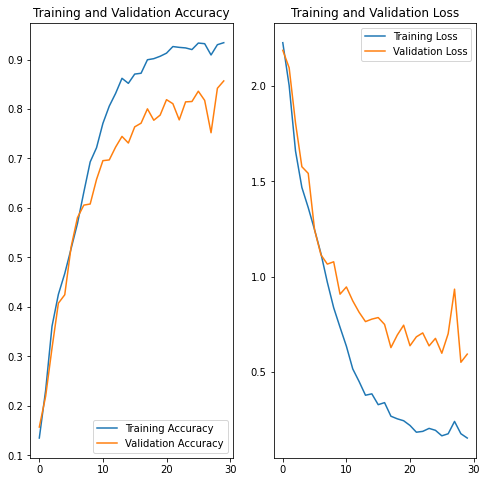

In [293]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



 - Once the class has been rebalnced the prediction accuracy  of training and validation are very close to each other and are also reasonbly high and hence this model  can be considered a good fit.